# Comparing Machine Learning Models for Stock Market Price Prediction

**CS 5805: Machine Learning Final Project**

Pranesh Ambokar, Mohammed Heydari, Roshan Ravindran, and Leo St. Amour

## Overview

Present an overview of the problem and our experimental design.

## Environmental Setup

Import relevant libraries and describe the purposes of each

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

2024-12-06 15:01:25.081936: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-06 15:01:25.192546: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-06 15:01:25.312034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733515285.453533    5649 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733515285.515629    5649 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 15:01:25.856426: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## Data Preprocessing

Describe our data and the steps for preparing it for our specific application
- Load the data (individual CSV)
- Aggregate the data
- Scale the data
- Train/test/validation split

TODO: move sequence creation function for LSTM here; describe why LSTM need the data parsed into sequences

In [2]:
# Define paths for the directories
mid_cap_path = './mid_cap'
large_cap_path = './large_cap'

# Load files from both directories
all_files = glob.glob(os.path.join(mid_cap_path, '*_data.csv')) + glob.glob(os.path.join(large_cap_path, '*_data.csv'))

df_list = []

for csv in all_files:
    df = pd.read_csv(csv)
    df['Stock'] = os.path.basename(csv).split('_')[0]  # Extract stock ticker from filename
    df_list.append(df)
data = pd.concat(df_list, ignore_index=True)
data = data.sort_values(['Stock', 'Date'])

In [3]:
# Create training/validation/testing sets using a 70/15/15 split
training_data = []
validation_data = []
testing_data = []

for stock in data['Stock'].unique():
    stock_data = data[data['Stock'] == stock]
    train_size = int(len(stock_data) * 0.7)
    val_size = int(len(stock_data) * 0.15)
    
    # Split the data for each stock
    training_data.append(stock_data.iloc[:train_size])
    validation_data.append(stock_data.iloc[train_size:train_size+val_size])
    testing_data.append(stock_data.iloc[train_size+val_size:])

# Concatenate the split data
training_data = pd.concat(training_data, ignore_index=True)
validation_data = pd.concat(validation_data, ignore_index=True)
testing_data = pd.concat(testing_data, ignore_index=True)

# Define the features (Open, Low, High) and target (Close)
training_X = training_data[['Open', 'Low', 'High']]
training_Y = training_data[['Close']]
validation_X = validation_data[['Open', 'Low', 'High']]
validation_Y = validation_data[['Close']]
testing_X = testing_data[['Open', 'Low', 'High']]
testing_Y = testing_data[['Close']]

# Check the number of features in the training data
num_features = training_X.shape[1]

# Output the split data for verification
print(f"Training data: {len(training_data)} rows")
print(f"Validation data: {len(validation_data)} rows")
print(f"Testing data: {len(testing_data)} rows")

num_features = training_X.shape[1]

Training data: 571741 rows
Validation data: 122477 rows
Testing data: 122631 rows


In [4]:
# Scale the data
scaler_X = MinMaxScaler(feature_range=(0, 1))  # For the features
scaler_Y = MinMaxScaler(feature_range=(0, 1))  # For the target (Close)

# Scale the features and target for training and testing sets
training_X_scaled = scaler_X.fit_transform(training_X)
testing_X_scaled = scaler_X.transform(testing_X)
validation_X_scaled = scaler_X.transform(validation_X)

# Scale the target variable (Close) for training and testing sets
training_Y_scaled = scaler_Y.fit_transform(training_Y)
testing_Y_scaled = scaler_Y.transform(testing_Y)
validation_Y_scaled = scaler_Y.transform(validation_Y)

## Linear Regression

In [5]:
%%time
from sklearn.linear_model import LinearRegression

linear_regression_model = LinearRegression()
linear_regression_model.fit(training_X_scaled, training_Y_scaled)

CPU times: user 377 ms, sys: 57.4 ms, total: 434 ms
Wall time: 465 ms


LinearRegression()

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def test_on_stock(model, stock_symbol, model_type='LR'):
    stock_data = testing_data[testing_data['Stock'] == stock_symbol]
    stock_X = stock_data[['Open', 'Low', 'High']]
    stock_Y = stock_data[['Close']]
    
    # Scale test data
    stock_X_scaled = scaler_X.transform(stock_X)
    stock_Y_scaled = scaler_Y.transform(stock_Y)

    if model_type == "LSTM":
        # Reshape stock_X_scaled to 3D array for LSTM (samples, time_steps, features)
        stock_X_scaled_3d = []
        for i in range(len(stock_X_scaled) - sequence_length):
            stock_X_scaled_3d.append(stock_X_scaled[i:i + sequence_length])
        stock_X_scaled_3d = np.array(stock_X_scaled_3d)
        
        # Make predictions using LSTM
        predictions_scaled = model.predict(stock_X_scaled_3d)
        
        # Inverse transform predictions and actual values to original scale
        predictions = scaler_Y.inverse_transform(predictions_scaled)
        actual_values = scaler_Y.inverse_transform(stock_Y_scaled[sequence_length:])

    else:
        # Make predictions
        predictions_scaled = model.predict(stock_X_scaled)
        predictions = scaler_Y.inverse_transform(predictions_scaled)
        actual_values = scaler_Y.inverse_transform(stock_Y_scaled)

    mse = mean_squared_error(actual_values, predictions)
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    r2 = r2_score(actual_values, predictions)  # R² score

    print(f"Mean Squared Error for {stock_symbol}: {mse}")
    print(f"Root Mean Squared Error (RMSE) for {stock_symbol}: {rmse}")
    print(f"R² Score for {stock_symbol}: {r2}")

    # Plot actual vs predicted prices for visualization
    plt.plot(actual_values, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.xlabel('Days')
    plt.ylabel('Dollars ($)')
    plt.legend()
    plt.title(f'{model_type}: {stock_symbol} - Actual vs Predicted Prices')
    plt.savefig(f'graphs/{stock_symbol}-{model_type}.png', bbox_inches='tight')
    plt.clf()

In [7]:
# Calculate correlation of features
correlation = training_data[['Open', 'Low', 'High', 'Close']].corr()['Close'].drop('Close')

# Retrieve regression coefficients from the trained linear regression model
coefficients = linear_regression_model.coef_.flatten()

feature_selection_table = pd.DataFrame({
    'Feature': ['Open', 'Low', 'High'],
    'Correlation with Close': correlation.values,
    'Regression Coefficient': coefficients
})

print(feature_selection_table)

  Feature  Correlation with Close  Regression Coefficient
0    Open                0.999881               -0.375897
1     Low                0.999956                0.661434
2    High                0.999959                0.711065


## LSTM

TODO: Is the data being transformed correctly? Is there a problem if the training/valid/test data is not a length that is a multiple of 60? The graphs at the end look like a similar shape but are offset (left and right) on some days...

In [8]:
def create_sequences(data, sequence_length, features, target):
    sequences = []
    targets = []
    
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]  # Get sequence of features
        target_value = data[i + sequence_length]  # Get target for the next time (Close)
        sequences.append(seq)
        targets.append(target_value)
    
    return np.array(sequences), np.array(targets)

# Step 6: Create sequences for training, validation, and testing
sequence_length = 60  # Define sequence length (60 days)

# For training data
X_train, y_train = create_sequences(training_X_scaled, sequence_length, ['Open', 'Low', 'High'], 'Close')

# For validation data
X_valid, y_valid = create_sequences(validation_X_scaled, sequence_length, ['Open', 'Low', 'High'], 'Close')

# For testing data
X_test, y_test = create_sequences(testing_X_scaled, sequence_length, ['Open', 'Low', 'High'], 'Close')

# Step 7: Reshape the data for LSTM (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], X_valid.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Check the shapes to confirm everything is correct
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (571681, 60, 3)
y_train shape: (571681, 3)
X_valid shape: (122417, 60, 3)
y_valid shape: (122417, 3)
X_test shape: (122571, 60, 3)
y_test shape: (122571, 3)


### Hyperparameter Tuning

In [ ]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Define the model
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=hp.Choice('units', [50, 100, 150]),
                   recurrent_dropout=hp.Choice('recurrent_dropout', [0.1, 0.2]),
                   return_sequences=False)) 
    model.add(Dropout(hp.Choice('dropout', [0.2, 0.3])))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.0005, 0.001, 0.005])),
                  loss='mean_squared_error')
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    directory='kt_dir',
    project_name='lstm_tuning_simple'
)

# Run the search
tuner.search(
    X_train, y_train,
    epochs=5,  # Fewer epochs for faster evaluation
    validation_data=(X_valid, y_valid),
    batch_size=32
)

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: {best_hyperparameters.values}")

best_lstm_model = tuner.hypermodel.build(best_hyperparameters)
history = best_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10,  
    batch_size=32
)

If the hyper-parameter tuning has already occurred, train the model directly using the best values

In [63]:
%%time
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Best Hyperparameters: {'units': 100, 'recurrent_dropout': 0.1, 'dropout': 0.3, 'learning_rate': 0.005}
best_lstm_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(units=100, recurrent_dropout=0.1, return_sequences=False),
    Dropout(0.3),
    Dense(units=1)
])
best_lstm_model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error')
    
# Train the model
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = best_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10,  
    batch_size=32
)

Epoch 1/10
17866/17866 ━━━━━━━━━━━━━━━━━━━━ 465s 26ms/step - loss: 8.5410e-05 - val_loss: 2.0931e-04
Epoch 2/10
17866/17866 ━━━━━━━━━━━━━━━━━━━━ 462s 26ms/step - loss: 3.0698e-05 - val_loss: 1.5239e-04
Epoch 3/10
17866/17866 ━━━━━━━━━━━━━━━━━━━━ 462s 26ms/step - loss: 2.1941e-05 - val_loss: 5.9473e-05
Epoch 4/10
17866/17866 ━━━━━━━━━━━━━━━━━━━━ 483s 27ms/step - loss: 2.2834e-05 - val_loss: 0.0031
Epoch 5/10
17866/17866 ━━━━━━━━━━━━━━━━━━━━ 464s 26ms/step - loss: 1.9321e-05 - val_loss: 0.0030
Epoch 6/10
17866/17866 ━━━━━━━━━━━━━━━━━━━━ 462s 26ms/step - loss: 1.4108e-05 - val_loss: 0.0022
Epoch 7/10
17866/17866 ━━━━━━━━━━━━━━━━━━━━ 462s 26ms/step - loss: 1.4414e-05 - val_loss: 0.0038
Epoch 8/10
17866/17866 ━━━━━━━━━━━━━━━━━━━━ 468s 26ms/step - loss: 1.4345e-05 - val_loss: 0.0010
Epoch 9/10
17866/17866 ━━━━━━━━━━━━━━━━━━━━ 469s 26ms/step - loss: 2.2389e-05 - val_loss: 2.6359e-04
Epoch 10/10
17866/17866 ━━━━━━━━━━━━━━━━━━━━ 468s 26ms/step - loss: 1.4157e-05 - val_loss: 0.0020
CPU times: us

### Save or Load Trained Model

In [64]:
best_lstm_model.save('lstm_trained.keras')

In [9]:
from tensorflow.keras.saving import load_model
best_lstm_model = load_model("lstm_trained.keras")

2024-12-06 15:02:15.471815: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Model Comparison

In [31]:
metrics = pd.DataFrame(columns=[
    'Stock', 'Model', 
    'Train Start', 'Train End', 
    'Test Start', 'Test End', 
    'MSE', 'MAE', 'RMSE', 'R2', 
    'Time to Train', 'Time to Predict',
    'Predictions'
])

def new_metric(stock_symbol, model):
    stock_training_data = training_data[training_data['Stock'] == stock_symbol]
    stock_testing_data = testing_data[testing_data['Stock'] == stock_symbol]

    stock_data = testing_data[testing_data['Stock'] == stock_symbol]
    stock_X = stock_data[['Open', 'Low', 'High']]
    stock_Y = stock_data[['Close']]
    
    # Scale test data
    stock_X_scaled = scaler_X.transform(stock_X)
    stock_Y_scaled = scaler_Y.transform(stock_Y)

    if model == 'LSTM':
        # Reshape stock_X_scaled to 3D array for LSTM (samples, time_steps, features)
        stock_X_scaled_3d = []
        for i in range(len(stock_X_scaled) - sequence_length):
            stock_X_scaled_3d.append(stock_X_scaled[i:i + sequence_length])
        stock_X_scaled_3d = np.array(stock_X_scaled_3d)
        
        # Make predictions using LSTM
        predictions_scaled = best_lstm_model.predict(stock_X_scaled_3d, verbose=0)
        
        # Inverse transform predictions and actual values to original scale
        predictions = scaler_Y.inverse_transform(predictions_scaled)
        actual_values = scaler_Y.inverse_transform(stock_Y_scaled[sequence_length:])
        stock_Y_scaled = stock_Y_scaled[sequence_length:]

    else:
        # Make predictions
        predictions_scaled = linear_regression_model.predict(stock_X_scaled)
        predictions = scaler_Y.inverse_transform(predictions_scaled)
        actual_values = scaler_Y.inverse_transform(stock_Y_scaled)

    mse = mean_squared_error(stock_Y_scaled, predictions_scaled)
    mae = mean_absolute_error(stock_Y_scaled, predictions_scaled)
    r2 = r2_score(actual_values, predictions)  # R² score
    
    return {
        'Stock': stock_symbol,
        'Model': model,
        'Train Start': stock_training_data['Date'].iloc[0],
        'Train End': stock_training_data['Date'].iloc[-1],
        'Test Start': stock_testing_data['Date'].iloc[0],
        'Test End': stock_testing_data['Date'].iloc[-1],
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
    }

for stock in data['Stock'].unique():
    metrics = metrics._append(new_metric(stock, 'LSTM'), ignore_index=True)
    metrics = metrics._append(new_metric(stock, 'Linear Regression'), ignore_index=True)
metrics

/tmp/ipykernel_5649/2359481737.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = metrics._append(new_metric(stock, 'LSTM'), ignore_index=True)


Stock              Model                Train Start  \
0    005930.KS               LSTM  2000-01-04 00:00:00+09:00   
1    005930.KS  Linear Regression  2000-01-04 00:00:00+09:00   
2      2222.SR               LSTM  2019-12-11 00:00:00+03:00   
3      2222.SR  Linear Regression  2019-12-11 00:00:00+03:00   
4    600519.SS               LSTM  2001-08-27 00:00:00+08:00   
..         ...                ...                        ...   
195       YELP  Linear Regression  2012-03-02 00:00:00-05:00   
196       ZBRA               LSTM  1991-08-15 00:00:00-04:00   
197       ZBRA  Linear Regression  1991-08-15 00:00:00-04:00   
198       ZION               LSTM  1980-03-17 00:00:00-05:00   
199       ZION  Linear Regression  1980-03-17 00:00:00-05:00   

                     Train End                 Test Start  \
0    2017-04-05 00:00:00+09:00  2021-02-02 00:00:00+09:00   
1    2017-04-05 00:00:00+09:00  2021-02-02 00:00:00+09:00   
2    2023-05-30 00:00:00+03:00  2024-02-25 00:00:00+03:00   
3    2023-05-30 00:00:00+03:00  2024-02-25 00:00:00+03:00   
4    2017-10-25 00:00:00+08:00  2021-05-13 00:00:00+08:00   
..                         ...                        ...   
195  2021-02-01 00:00:00-05:00  2022-12-28 00:00:00-05:00   
196  2014-11-26 00:00:00-05:00  2019-11-26 00:00:00-05:00   
197  2014-11-26 00:00:00-05:00  2019-11-26 00:00:00-05:00   
198  2011-06-20 00:00:00-04:00  2018-03-09 00:00:00-05:00   
199  2011-06-20 00:00:00-04:00  2018-03-09 00:00:00-05:00   

                      Test End           MSE       MAE RMSE         R2  \
0    2024-11-26 00:00:00+09:00  1.718051e+00  1.291654  NaN -33.005301   
1    2024-11-26 00:00:00+09:00  1.047147e-04  0.008220  NaN   0.997984   
2    2024-11-26 00:00:00+03:00  1.187878e-08  0.000109  NaN -57.573390   
3    2024-11-26 00:00:00+03:00  2.122870e-09  0.000046  NaN  -0.743424   
4    2024-11-26 00:00:00+08:00  1.529482e-06  0.000965  NaN   0.887262   
..                         ...           ...       ...  ...        ...   
195  2024-11-26 00:00:00-05:00  2.142295e-09  0.000046  NaN   0.907104   
196  2024-11-26 00:00:00-05:00  1.390780e-07  0.000298  NaN   0.985866   
197  2024-11-26 00:00:00-05:00  9.542538e-09  0.000076  NaN   0.999018   
198  2024-11-26 00:00:00-05:00  9.190022e-09  0.000090  NaN   0.875841   
199  2024-11-26 00:00:00-05:00  2.245474e-09  0.000046  NaN   0.968677   

    Time to Train Time to Predict Predictions  
0             NaN             NaN         NaN  
1             NaN             NaN         NaN  
2             NaN             NaN         NaN  
3             NaN             NaN         NaN  
4             NaN             NaN         NaN  
..            ...             ...         ...  
195           NaN             NaN         NaN  
196           NaN             NaN         NaN  
197           NaN             NaN         NaN  
198           NaN             NaN         NaN  
199           NaN             NaN         NaN  

[200 rows x 13 columns]

In [24]:
%%time
for stock_symbol in data['Stock'].unique():
    test_on_stock(linear_regression_model, stock_symbol)
    test_on_stock(best_lstm_model, stock_symbol, model_type='LSTM')

Mean Squared Error for 005930.KS: 126787.59569556585
Root Mean Squared Error (RMSE) for 005930.KS: 356.0724584906362
R² Score for 005930.KS: 0.9979840898834327
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Mean Squared Error for 005930.KS: 2080200046.2498724
Root Mean Squared Error (RMSE) for 005930.KS: 45609.2101033319
R² Score for 005930.KS: -33.00530114243589
Mean Squared Error for 2222.SR: 2.570351317584049
Root Mean Squared Error (RMSE) for 2222.SR: 1.603231523387701
R² Score for 2222.SR: -0.7434239052459619
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Mean Squared Error for 2222.SR: 14.382707639812029
Root Mean Squared Error (RMSE) for 2222.SR: 3.792454039248469
R² Score for 2222.SR: -57.57339048962304
Mean Squared Error for 600519.SS: 120.44427540994748
Root Mean Squared Error (RMSE) for 600519.SS: 10.974710721014358
R² Score for 600519.SS: 0.9939747486120406
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Mean Squared Error for 600519.SS: 1851.8835044956577
Root Mean Squared Error (RMSE) for 600519

<Figure size 432x288 with 0 Axes>

In [68]:
print(metrics[metrics['Model'] == 'LSTM']['R2'].describe())
print(metrics[metrics['Model'] == 'Linear Regression']['R2'].describe())

count    100.000000
mean      -0.061432
std        6.753359
min      -57.573390
25%        0.912855
50%        0.977283
75%        0.990870
max        0.998832
Name: R2, dtype: float64
count    100.000000
mean       0.956476
std        0.176965
min       -0.743424
25%        0.970335
50%        0.988275
75%        0.997126
max        0.999627
Name: R2, dtype: float64


We observe some (large) negative values... Let's isolate and remove those

In [25]:
stocks_to_keep = metrics.groupby('Stock')['R2'].transform(lambda x: x.min() >= 0)
stocks_with_negative_r2 = metrics.groupby('Stock')['R2'].transform(lambda x: x.min() < 0)

good_metrics = metrics[stocks_to_keep]
suspicious_metrics = metrics[stocks_with_negative_r2]

In [26]:
print(good_metrics[good_metrics['Model'] == 'LSTM']['R2'].describe())
print(good_metrics[good_metrics['Model'] == 'Linear Regression']['R2'].describe())

count    96.000000
mean      0.935895
std       0.112403
min       0.290762
25%       0.937110
50%       0.978954
75%       0.991427
max       0.998832
Name: R2, dtype: float64
count    96.000000
mean      0.977783
std       0.027252
min       0.881954
25%       0.971851
50%       0.988644
75%       0.997126
max       0.999627
Name: R2, dtype: float64


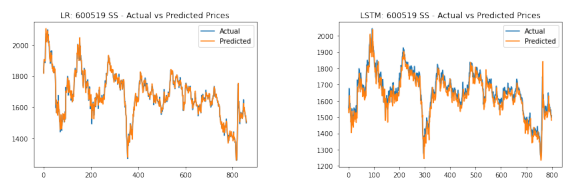

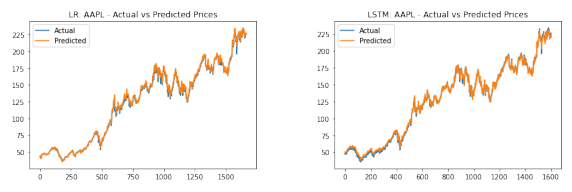

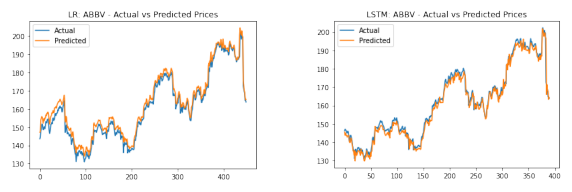

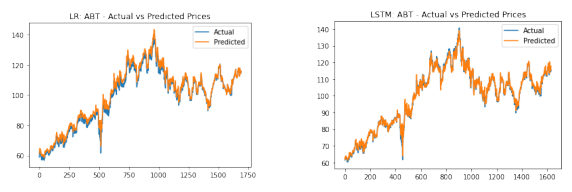

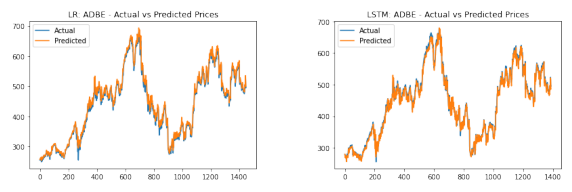

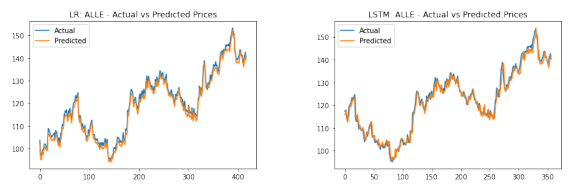

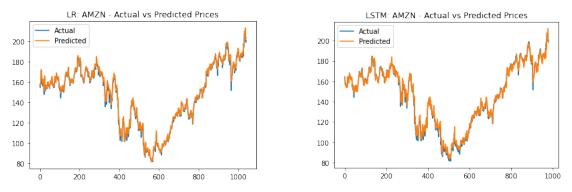

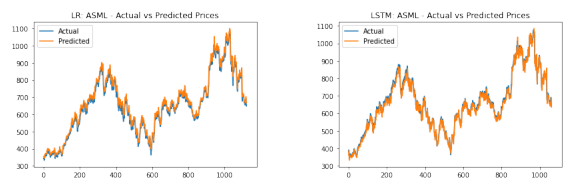

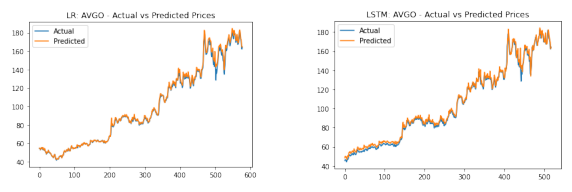

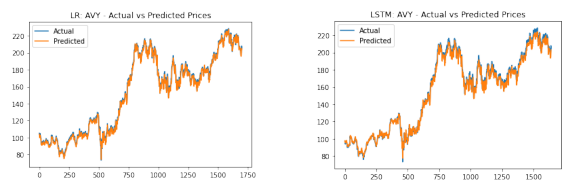

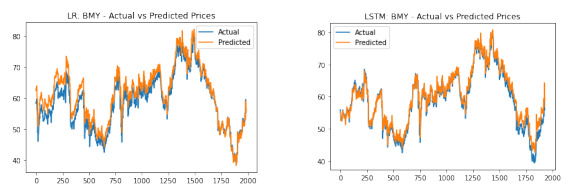

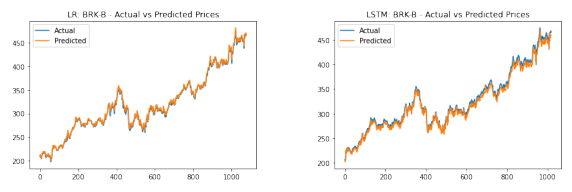

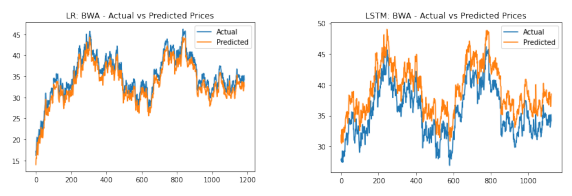

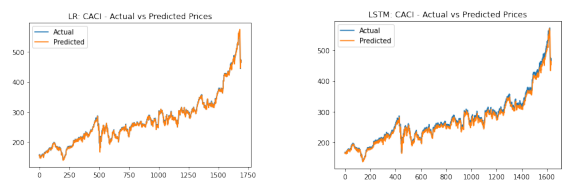

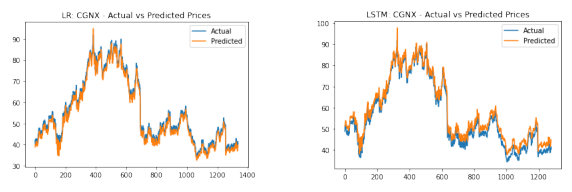

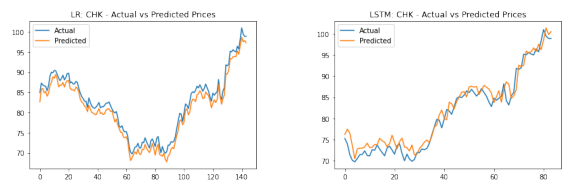

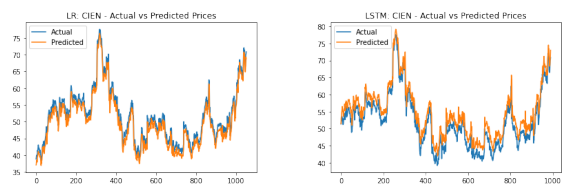

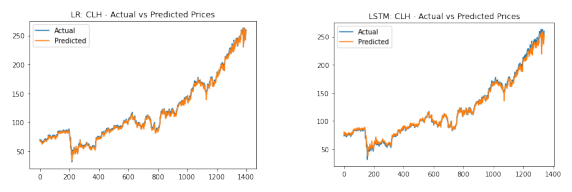

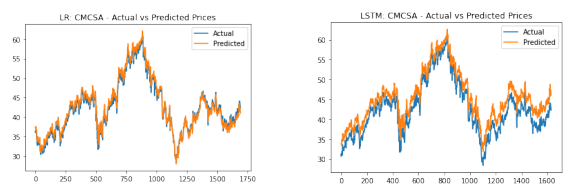

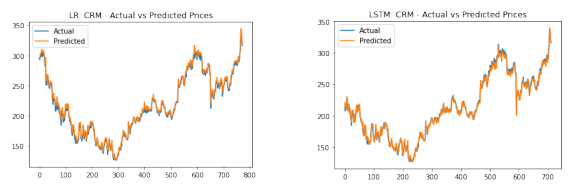

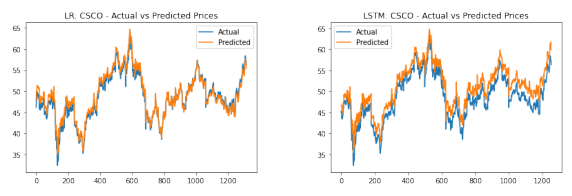

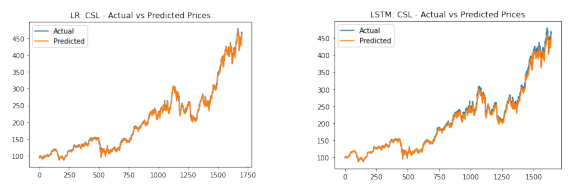

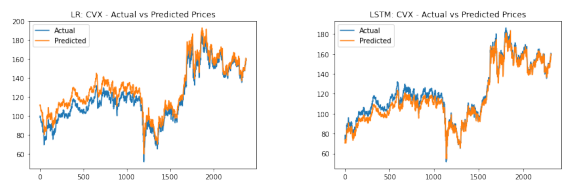

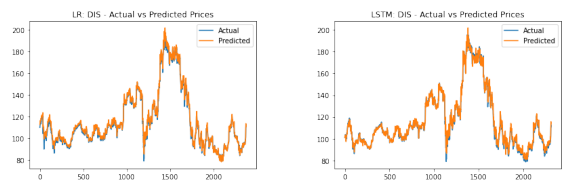

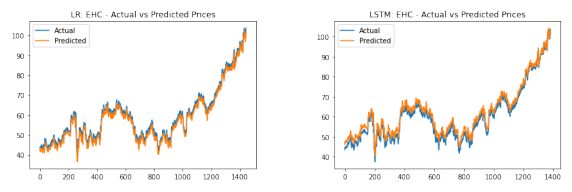

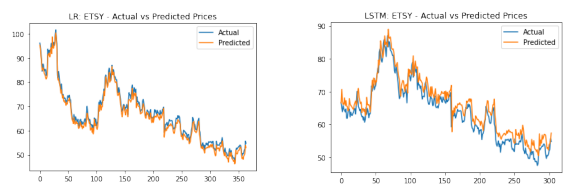

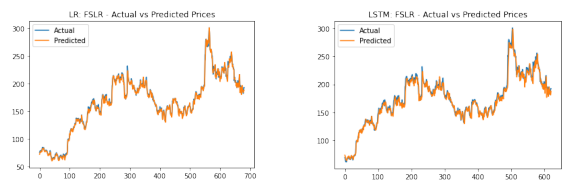

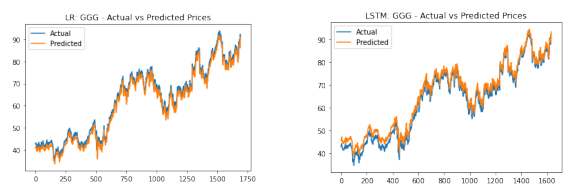

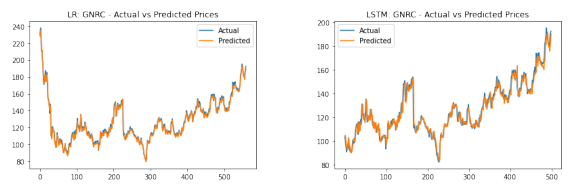

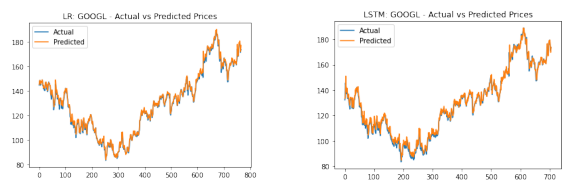

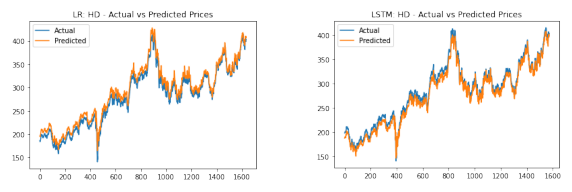

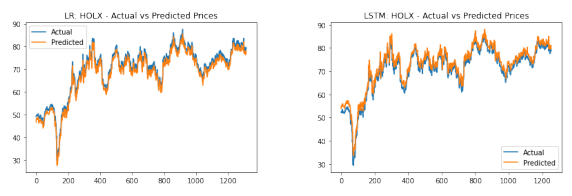

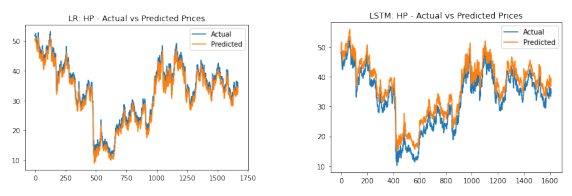

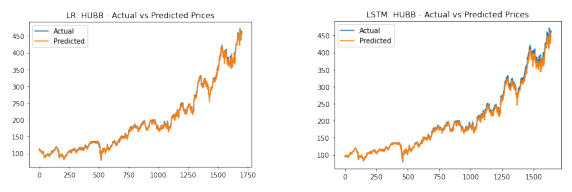

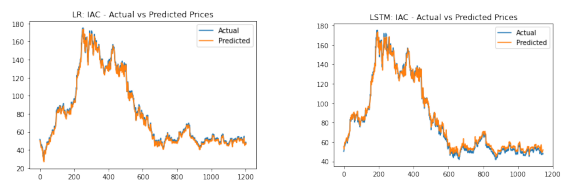

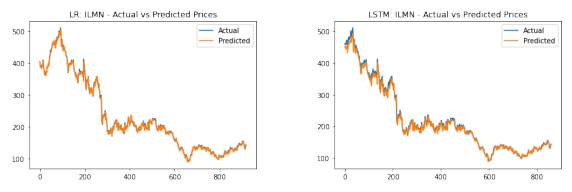

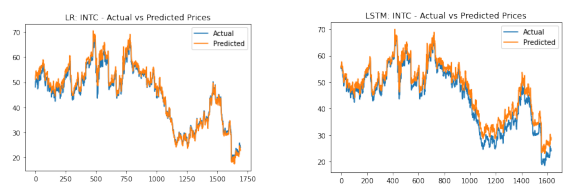

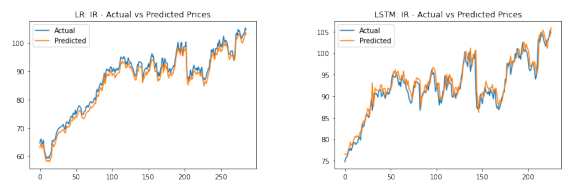

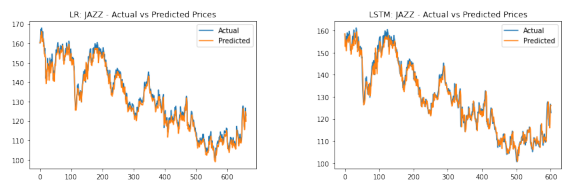

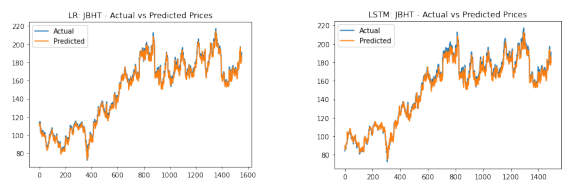

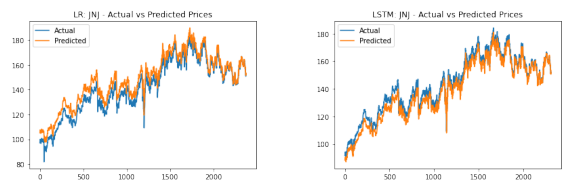

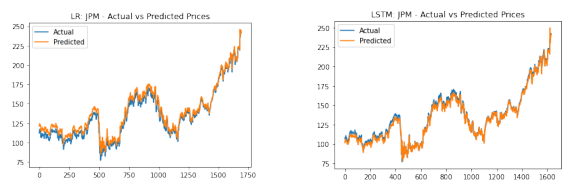

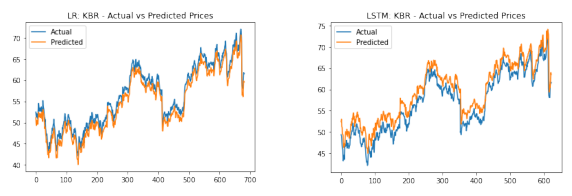

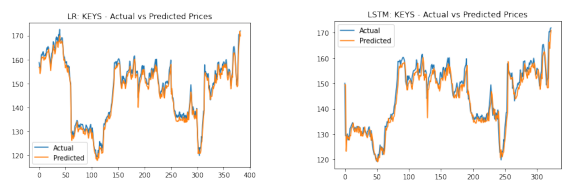

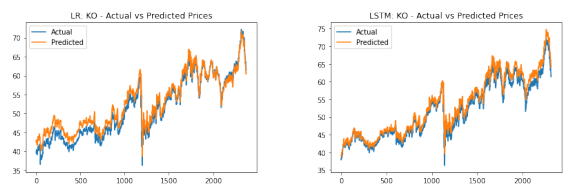

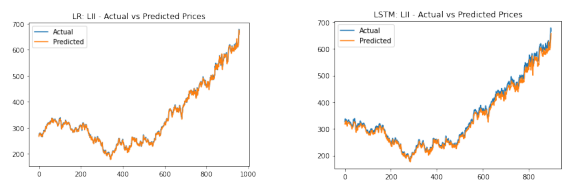

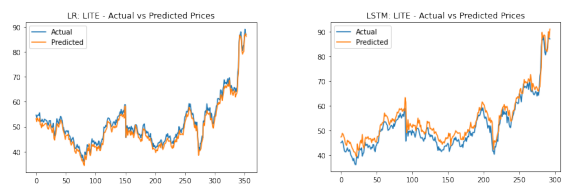

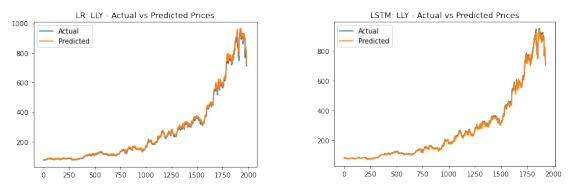

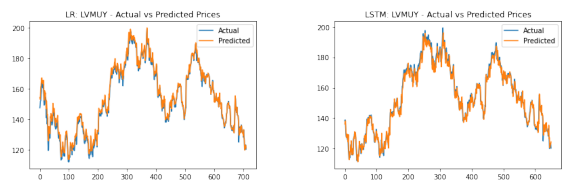

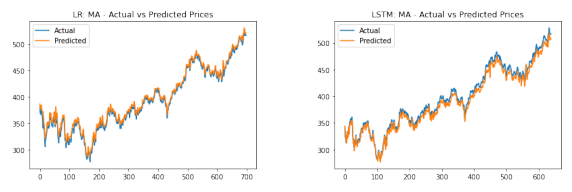

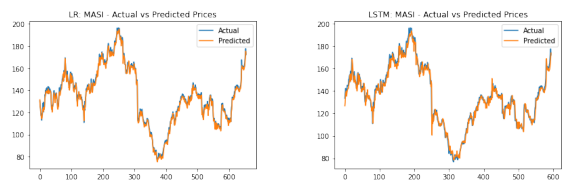

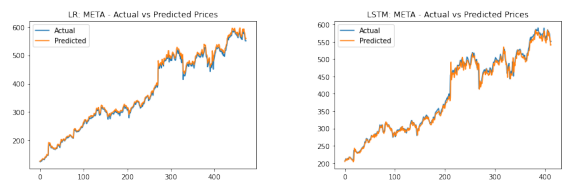

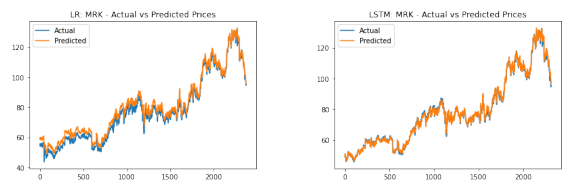

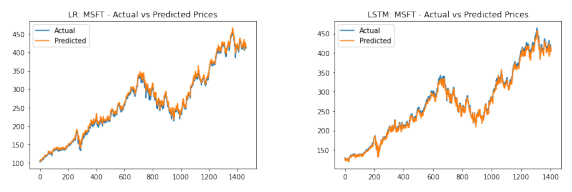

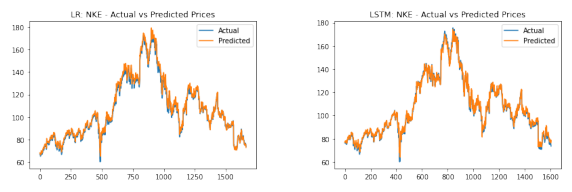

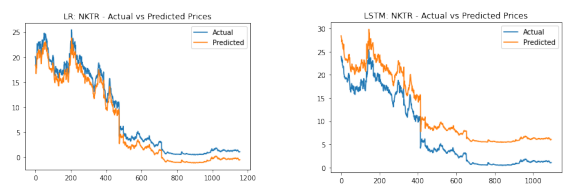

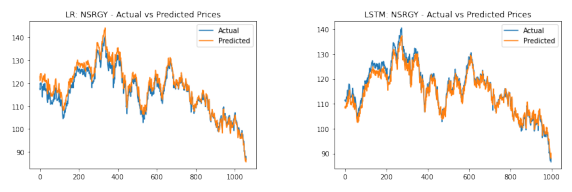

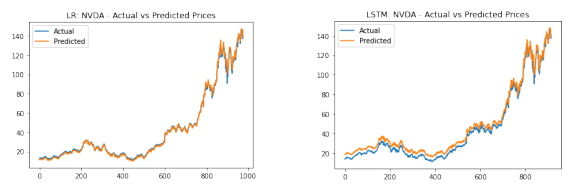

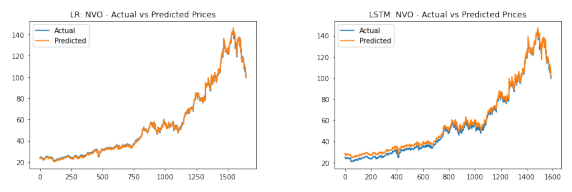

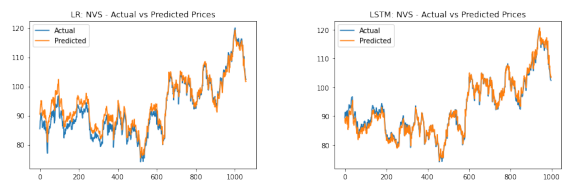

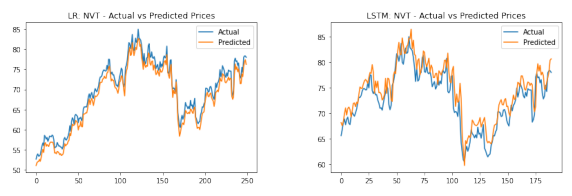

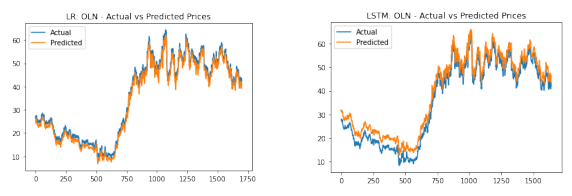

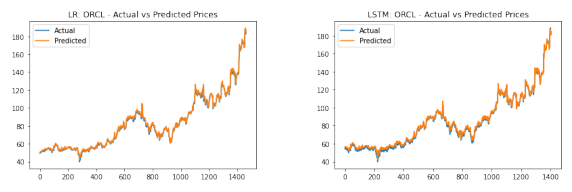

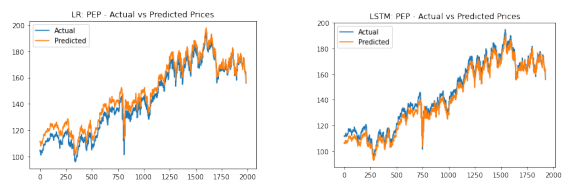

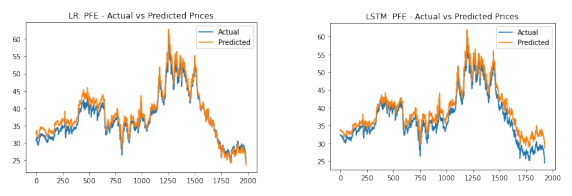

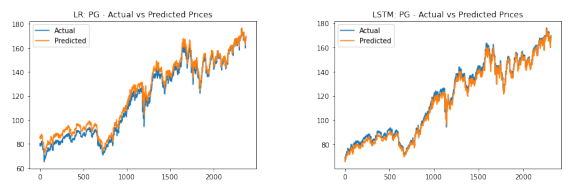

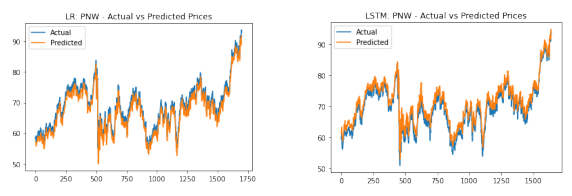

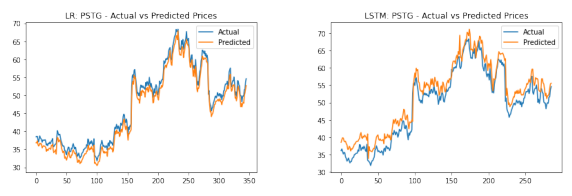

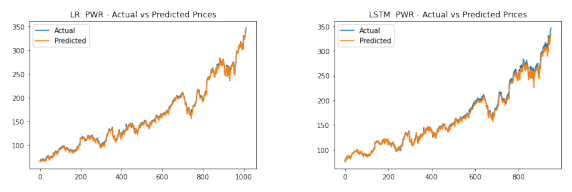

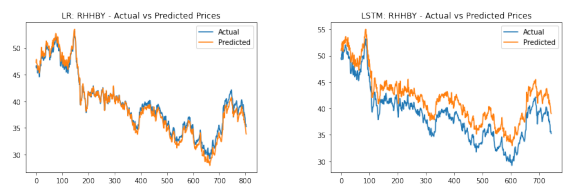

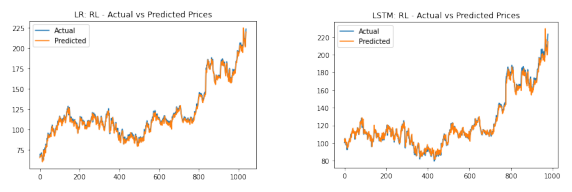

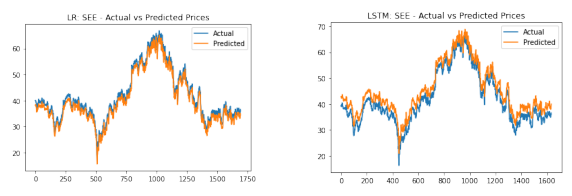

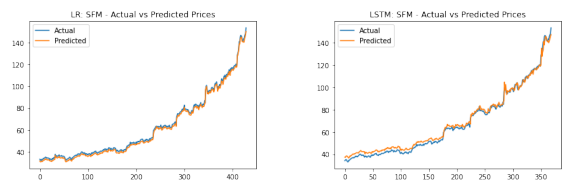

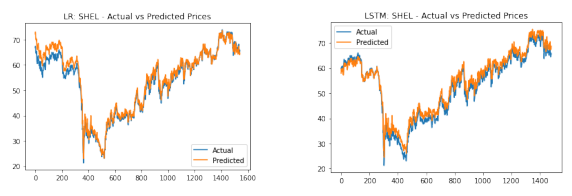

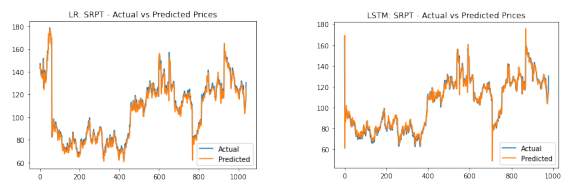

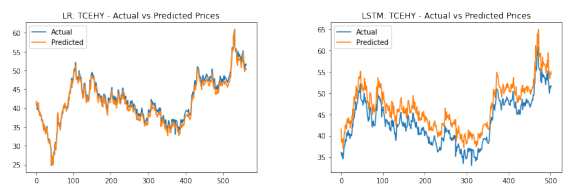

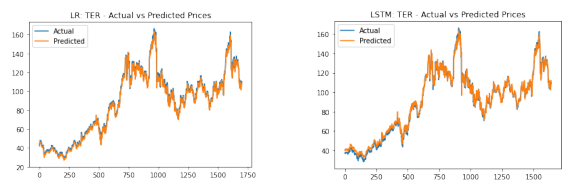

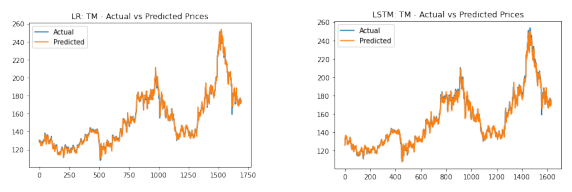

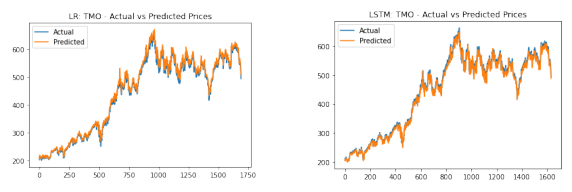

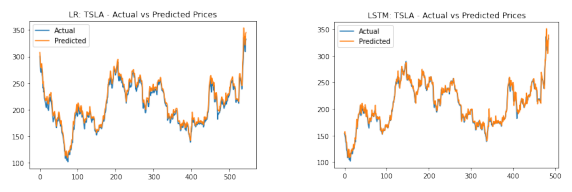

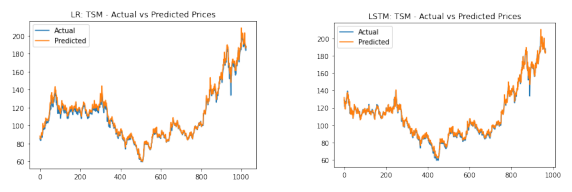

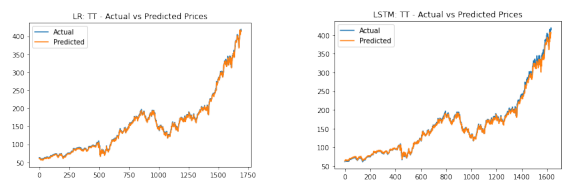

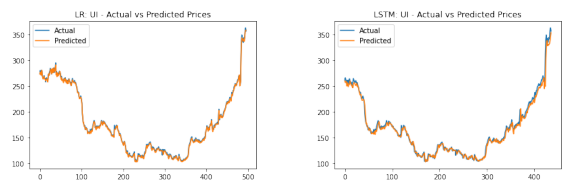

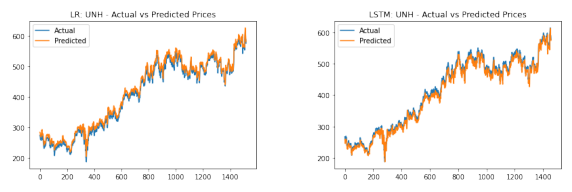

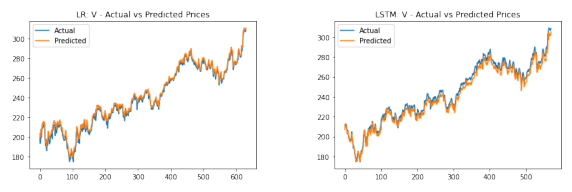

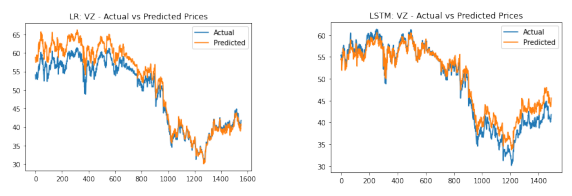

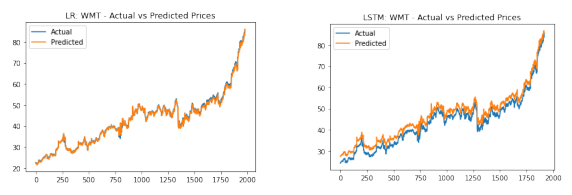

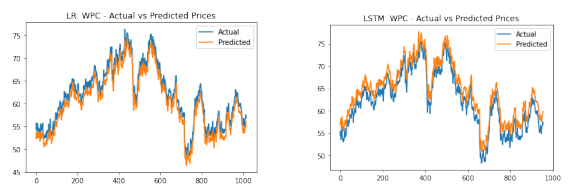

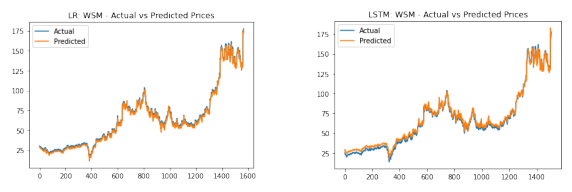

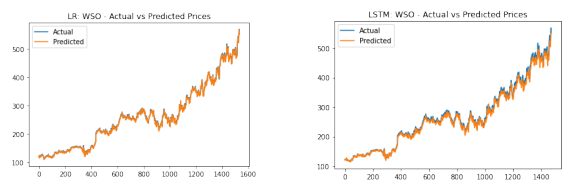

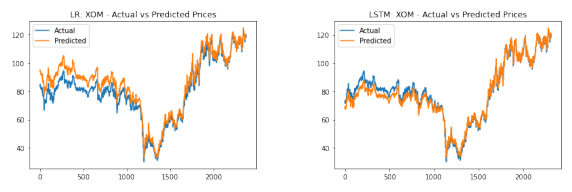

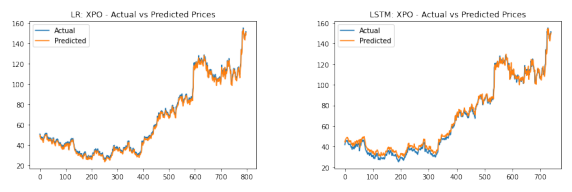

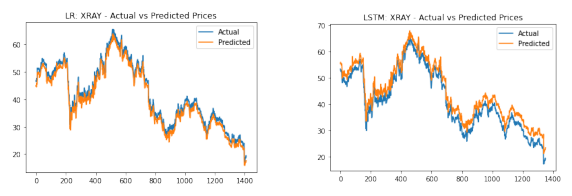

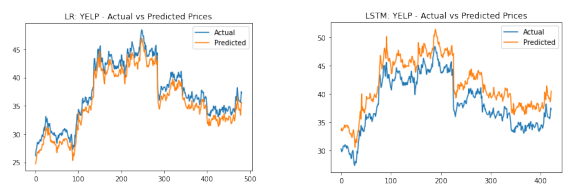

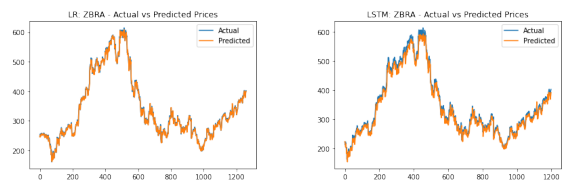

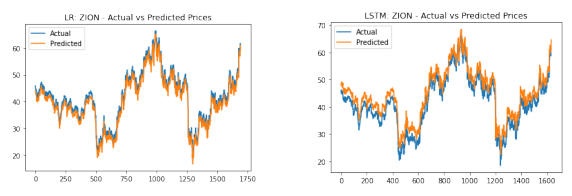

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_graphs(stock_symbol):
    image1 = mpimg.imread(f'graphs/{stock_symbol}-LR.png')
    image2 = mpimg.imread(f'graphs/{stock_symbol}-LSTM.png')

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

    # Display image 1
    axs[0].imshow(image1)
    axs[0].axis('off')  # Turn off axis for the first subplot

    # Display image 2
    axs[1].imshow(image2)
    axs[1].axis('off')  # Turn off axis for the second subplot

    # Show the plot
    plt.show()

for stock in good_metrics['Stock'].unique():
    show_graphs(stock)

In [14]:
print(suspicious_metrics.describe())
suspicious_metrics

                MSE          RMSE         R2
count  8.000000e+00      8.000000   8.000000
mean   2.600409e+08   5747.733033 -11.776076
std    7.354554e+08  16106.943528  21.789887
min    2.570351e+00      1.603232 -57.573390
25%    2.613370e+00      1.616590 -12.085507
50%    1.237233e+01      3.505726  -0.520785
75%    3.171372e+04     92.570455   0.713040
max    2.080200e+09  45609.210103   0.997984


Stock              Model                Train Start  \
0    005930.KS               LSTM  2000-01-04 00:00:00+09:00   
1    005930.KS  Linear Regression  2000-01-04 00:00:00+09:00   
2      2222.SR               LSTM  2019-12-11 00:00:00+03:00   
3      2222.SR  Linear Regression  2019-12-11 00:00:00+03:00   
64         HBI               LSTM  2006-09-06 00:00:00-04:00   
65         HBI  Linear Regression  2006-09-06 00:00:00-04:00   
176        VVV               LSTM  2016-09-23 00:00:00-04:00   
177        VVV  Linear Regression  2016-09-23 00:00:00-04:00   

                     Train End                 Test Start  \
0    2017-04-05 00:00:00+09:00  2021-02-02 00:00:00+09:00   
1    2017-04-05 00:00:00+09:00  2021-02-02 00:00:00+09:00   
2    2023-05-30 00:00:00+03:00  2024-02-25 00:00:00+03:00   
3    2023-05-30 00:00:00+03:00  2024-02-25 00:00:00+03:00   
64   2019-06-10 00:00:00-04:00  2022-03-03 00:00:00-05:00   
65   2019-06-10 00:00:00-04:00  2022-03-03 00:00:00-05:00   
176  2022-06-13 00:00:00-04:00  2023-09-06 00:00:00-04:00   
177  2022-06-13 00:00:00-04:00  2023-09-06 00:00:00-04:00   

                      Test End           MSE  MAE          RMSE         R2  \
0    2024-11-26 00:00:00+09:00  2.080200e+09  NaN  45609.210103 -33.005301   
1    2024-11-26 00:00:00+09:00  1.267876e+05  NaN    356.072458   0.997984   
2    2024-11-26 00:00:00+03:00  1.438271e+01  NaN      3.792454 -57.573390   
3    2024-11-26 00:00:00+03:00  2.570351e+00  NaN      1.603232  -0.743424   
64   2024-11-26 00:00:00-05:00  2.243399e+01  NaN      4.736453  -5.112242   
65   2024-11-26 00:00:00-05:00  2.600689e+00  NaN      1.612665   0.663123   
176  2024-11-26 00:00:00-05:00  1.036195e+01  NaN      3.218999  -0.298146   
177  2024-11-26 00:00:00-05:00  2.617596e+00  NaN      1.617899   0.862790   

    Time to Train Time to Predict Predictions  
0             NaN             NaN         NaN  
1             NaN             NaN         NaN  
2             NaN             NaN         NaN  
3             NaN             NaN         NaN  
64            NaN             NaN         NaN  
65            NaN             NaN         NaN  
176           NaN             NaN         NaN  
177           NaN             NaN         NaN

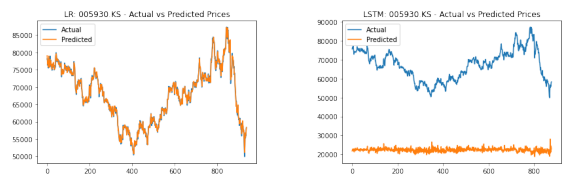

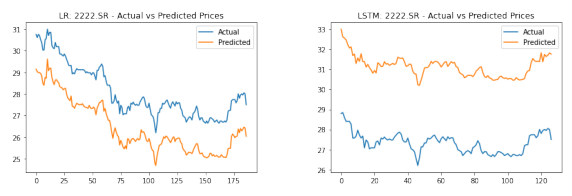

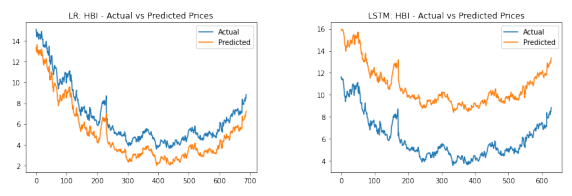

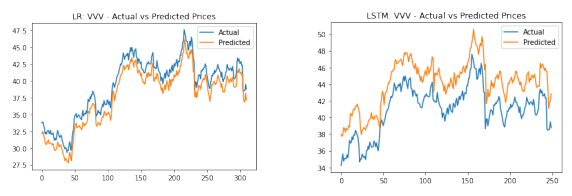

In [15]:
for stock in suspicious_metrics['Stock'].unique():
    show_graphs(stock)

## Conclusion

## References

In [30]:
print(good_metrics[good_metrics['Model'] == 'LSTM'].describe())
print(good_metrics[good_metrics['Model'] == 'Linear Regression'].describe())

                MSE        MAE         R2
count  9.600000e+01  96.000000  96.000000
mean   3.894118e-08   0.000110   0.935895
std    1.589024e-07   0.000111   0.112403
min    1.073158e-09   0.000023   0.290762
25%    5.634920e-09   0.000063   0.937110
50%    9.142392e-09   0.000080   0.978954
75%    2.111002e-08   0.000121   0.991427
max    1.529482e-06   0.000965   0.998832
                MSE        MAE         R2
count  9.600000e+01  96.000000  96.000000
mean   1.448265e-08   0.000076   0.977783
std    3.523183e-08   0.000073   0.027252
min    2.210366e-10   0.000011   0.881954
25%    2.259764e-09   0.000046   0.971851
50%    3.170435e-09   0.000048   0.988644
75%    7.109775e-09   0.000068   0.997126
max    2.821536e-07   0.000480   0.999627


In [98]:
# randomly select X stocks
days = 30
stocks = np.random.choice(data['Stock'].unique(), 2)
print(stocks)

foo = {}

for stock in stocks:
    # for days -1 through -10:
    test_rows = testing_data[testing_data['Stock'] == stock].tail(days)
    test_open = test_rows['Open']
    test_close = test_rows['Close']
    actual_diffs = test_close - test_open


    stock_X = test_rows[['Open', 'Low', 'High']]
    stock_Y = test_rows[['Close']]
    
    # Scale test data
    stock_X_scaled = scaler_X.transform(stock_X)
    stock_Y_scaled = scaler_Y.transform(stock_Y)

    '''
if model == 'LSTM':
        # Reshape stock_X_scaled to 3D array for LSTM (samples, time_steps, features)
        stock_X_scaled_3d = []
        for i in range(len(stock_X_scaled) - sequence_length):
            stock_X_scaled_3d.append(stock_X_scaled[i:i + sequence_length])
        stock_X_scaled_3d = np.array(stock_X_scaled_3d)
        
        # Make predictions using LSTM
        predictions_scaled = best_lstm_model.predict(stock_X_scaled_3d, verbose=0)
        
        # Inverse transform predictions and actual values to original scale
        predictions = scaler_Y.inverse_transform(predictions_scaled)
        actual_values = scaler_Y.inverse_transform(stock_Y_scaled[sequence_length:])
        stock_Y_scaled = stock_Y_scaled[sequence_length:]

    else:
'''
    # Make predictions
    predictions_scaled = linear_regression_model.predict(stock_X_scaled)
    predictions = scaler_Y.inverse_transform(predictions_scaled)
    predicted_diffs = predictions[0] - test_open

    foo[stock] = (predicted_diffs, actual_diffs)
# get prediction for each model
# get actual
# calculate diff between prediction and open and acutal and open
# output stock with greatest diff

# compare output stock from prediction with output stock of actual

correct = 0

for day in range(days):
    #print(f'Day {day}')
    best_stock_diff = 0
    best_stock = ''
    best_stock_diff2 = 0
    best_stock2 = ''
    for stock in stocks:
        predicted = foo[stock][0].iloc[day]
        if predicted > best_stock_diff:
            best_stock_diff = predicted
            best_stock = stock
        actual = foo[stock][1].iloc[day]
        if actual > best_stock_diff2:
            best_stock_diff2 = actual
            best_stock2 = stock
    #print(best_stock)
    #print(best_stock_diff)
    #print(best_stock2)
    #print(best_stock_diff2)
    if best_stock == best_stock2:
        correct += 1

print(f'Accuracy: {correct / days}')

['NVT' 'JPM']
Accuracy: 0.43333333333333335
